# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [1]:
#%pip install wandb

In [2]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [3]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [4]:
wandb.init(project='precursor_charge_multilabel')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [5]:
#%pip install seaborn

In [5]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [6]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [7]:
import re
# the dictionary
aa_syntax_dictionary = dict()
for index, i in enumerate(list('XACDEFGHIKLMNPQRSTVWY')): # added X for 0 value
    aa_syntax_dictionary[i] = index * 100
    if i != 'X': # ignore 0 value for X
        for count in range(0, 100):
            aa_syntax_dictionary[i + "[UNIMOD:" + str(count) + "]"] = index * 100 + count

def seq_translator(sequence, dictionary=aa_syntax_dictionary, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    if print_result:
        print(result)
    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (50 - len(result))

    return [dictionary[aa] for aa in result]


def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [10]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [12]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    if counter > 2:
        break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [13]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [14]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,LPGSLETYVEQEQGENANDR,2,29525630.0
1,HGSLQEYLQNDTGSK,2,13188580.0
2,VEEEEEINSELTAR,2,20663460.0
3,LPGSLETYVEQEQGENANDR,2,19884630.0
4,NSSTAEINETTTSSTDFLAR,2,12804420.0


In [16]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [17]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Normalisieren:

In [18]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [19]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [20]:
# load all parquets into df
df_dict = dict()
for file in file_list[:2]: # TODO change
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_31500\1886356924.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_31500\1886356924.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


In [99]:
merged_df = pd.concat(list(df_dict.values())[:-1]).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_31500\3965802802.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())[:-1]).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()


In [100]:
merged_df['distributions'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [101]:
# get percentages for each key in distributions according to values
merged_df['dist_percentages'] = merged_df.apply(lambda x: {key: value / sum(x["distributions"].values()) for key, value in x["distributions"].items()}, axis=1)

In [102]:
def multi_label_one_hot_precursor(charge_list, charges_included=charge_ranges):

    one_hot_encoded = [1 if label in charge_list else 0 for label in charges_included]

    return one_hot_encoded

In [103]:
merged_df['multi_label_vector'] = merged_df['precursor_charge'].apply(multi_label_one_hot_precursor)

In [93]:
merged_df.head(10)

,modified_sequence,precursor_charge,precursor_intensity,distributions,dist_percentages,multi_label_vector
0,AAAASAAEAGIATTGTEGER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, ...","[165006700.0, 73345890.0, 16215490.0, 73345890...","{2: 695065.6, 3: 2633379.0}","{2: 0.2088259483123138, 3: 0.7911740516876862}","[0, 1, 1, 0, 0, 0]"
1,AAAC[UNIMOD:4]FFEQPPR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1118398000.0, 894762400.0, 48477320.0, 707426...",{2: 7535501.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
2,AAADFATHGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[950304000.0, 69180770.0, 52745530.0, 69180770...",{2: 341550.9},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
3,AAADLMAYC[UNIMOD:4]EAHAK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[11874490.0, 11874490.0, 10890660.0, 14086870....",{2: 14086870.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
4,AAADSDPNLDPLMNPHIR,"[3, 3, 3, 3]","[58026060.0, 58026060.0, 8447297.0, 8447297.0]",{3: 8447297.0},{3: 1.0},"[0, 0, 1, 0, 0, 0]"
5,AAADSDPNLDPLM[UNIMOD:35]NPHIR,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[7103406.0, 11804630.0, 11804630.0, 7433404.0,...",{3: 6419643.0},{3: 1.0},"[0, 0, 1, 0, 0, 0]"
6,AAADTLAVR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1648339000.0, 350787600.0, 1648339000.0, 3507...",{2: 254997.2},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
7,AAAEATQETVESLMQK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[71326430.0, 74987410.0, 71326430.0, 28122350....",{2: 1298560.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
8,AAAEATQETVESLM[UNIMOD:35]QK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[9525848.0, 8286842.0, 9525848.0, 8286842.0, 5...",{2: 8895769.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]"
9,AAAEIYEEFLAAFEGSDGNK,"[2, 2]","[10863660.0, 10863660.0]",{2: 10863660.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]"


In [104]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator)

In [105]:
merged_df.head(11)

,modified_sequence,precursor_charge,precursor_intensity,distributions,dist_percentages,multi_label_vector,modified_sequence_vector
0,AAAASAAEAGIATTGTEGER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, ...","[165006700.0, 73345890.0, 16215490.0, 73345890...","{2: 695065.6, 3: 2633379.0}","{2: 0.2088259483123138, 3: 0.7911740516876862}","[0, 1, 1, 0, 0, 0]","[100, 100, 100, 100, 1600, 100, 100, 400, 100,..."
1,AAAC[UNIMOD:4]FFEQPPR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1118398000.0, 894762400.0, 48477320.0, 707426...",{2: 7535501.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 204, 500, 500, 400, 1400, 1300..."
2,AAADFATHGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[950304000.0, 69180770.0, 52745530.0, 69180770...",{2: 341550.9},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 300, 500, 100, 1700, 700, 600,..."
3,AAADLMAYC[UNIMOD:4]EAHAK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[11874490.0, 11874490.0, 10890660.0, 14086870....",{2: 14086870.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 300, 1000, 1100, 100, 2000, 20..."
4,AAADSDPNLDPLMNPHIR,"[3, 3, 3, 3]","[58026060.0, 58026060.0, 8447297.0, 8447297.0]",{3: 8447297.0},{3: 1.0},"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 300, 1600, 300, 1300, 1200, 10..."
5,AAADSDPNLDPLM[UNIMOD:35]NPHIR,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[7103406.0, 11804630.0, 11804630.0, 7433404.0,...",{3: 6419643.0},{3: 1.0},"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 300, 1600, 300, 1300, 1200, 10..."
6,AAADTLAVR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1648339000.0, 350787600.0, 1648339000.0, 3507...",{2: 254997.2},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 300, 1700, 1000, 100, 1800, 15..."
7,AAAEATQETVESLMQK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[71326430.0, 74987410.0, 71326430.0, 28122350....",{2: 1298560.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 400, 100, 1700, 1400, 400, 170..."
8,AAAEATQETVESLM[UNIMOD:35]QK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[9525848.0, 8286842.0, 9525848.0, 8286842.0, 5...",{2: 8895769.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 400, 100, 1700, 1400, 400, 170..."
9,AAAEIYEEFLAAFEGSDGNK,"[2, 2]","[10863660.0, 10863660.0]",{2: 10863660.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 400, 800, 2000, 400, 400, 500,..."


In [47]:
len(merged_df)

70445

In [106]:
print(file_list[0])
look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
len(look_up_df)

data/Thermo_SRM_Pool_meta_data.parquet


C:\Users\micro\AppData\Local\Temp\ipykernel_31500\365009680.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


70445

# Dataset preprocessing

In [95]:
batches_parquet[file_list[0]]['precursor_charge'].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

In [96]:
batches_parquet[file_list[1]]['precursor_charge'].value_counts()

2    1401912
3     787278
4     220159
5      34381
1      26371
6       4417
Name: precursor_charge, dtype: int64

In [107]:
merged_df['multi_label_vector'].value_counts()

[0, 1, 0, 0, 0, 0]    41772
[0, 1, 1, 0, 0, 0]    17634
[0, 0, 1, 0, 0, 0]     6320
[0, 0, 1, 1, 0, 0]     1631
[0, 1, 1, 1, 0, 0]     1543
[0, 0, 0, 1, 0, 0]      668
[1, 1, 0, 0, 0, 0]      481
[0, 0, 1, 1, 1, 0]       96
[0, 1, 0, 1, 0, 0]       74
[0, 0, 0, 0, 0, 1]       55
[0, 0, 0, 0, 1, 0]       42
[0, 0, 0, 1, 1, 0]       42
[1, 0, 0, 0, 0, 0]       30
[0, 1, 1, 1, 1, 0]       27
[1, 1, 1, 0, 0, 0]       14
[0, 0, 1, 0, 1, 0]        6
[0, 0, 0, 0, 1, 1]        3
[0, 0, 0, 1, 1, 1]        2
[0, 0, 1, 0, 0, 1]        2
[0, 0, 1, 1, 1, 1]        2
[0, 1, 0, 1, 1, 0]        1
Name: multi_label_vector, dtype: int64

In [ ]:
# "[0, 1, 0, 0, 0, 0]",41772
# "[0, 1, 1, 0, 0, 0]",17634
# "[0, 0, 1, 0, 0, 0]",6320
# "[0, 0, 1, 1, 0, 0]",1631
# "[0, 1, 1, 1, 0, 0]",1543
# "[0, 0, 0, 1, 0, 0]",668
# "[1, 1, 0, 0, 0, 0]",481
# "[0, 0, 1, 1, 1, 0]",96
# "[0, 1, 0, 1, 0, 0]",74
# "[0, 0, 0, 0, 0, 1]",55
# "[0, 0, 0, 0, 1, 0]",42
# "[0, 0, 0, 1, 1, 0]",42
# "[1, 0, 0, 0, 0, 0]",30
# "[0, 1, 1, 1, 1, 0]",27
# "[1, 1, 1, 0, 0, 0]",14
# "[0, 0, 1, 0, 1, 0]",6
# "[0, 0, 0, 0, 1, 1]",3
# "[0, 0, 0, 1, 1, 1]",2
# "[0, 0, 1, 0, 0, 1]",2
# "[0, 0, 1, 1, 1, 1]",2
# "[0, 1, 0, 1, 1, 0]",1

In [150]:
value_counts = merged_df['multi_label_vector'].value_counts()
# get value of value counts that are less than 1 and extract values
item_to_erase = value_counts[value_counts <= 1].index.values[0]

# search row with value in column
merged_df.loc[merged_df['multi_label_vector']!=0]

,modified_sequence,precursor_charge,precursor_intensity,distributions,dist_percentages,multi_label_vector,modified_sequence_vector
0,AAAASAAEAGIATTGTEGER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, ...","[165006700.0, 73345890.0, 16215490.0, 73345890...","{2: 695065.6, 3: 2633379.0}","{2: 0.2088259483123138, 3: 0.7911740516876862}","[0, 1, 1, 0, 0, 0]","[100, 100, 100, 100, 1600, 100, 100, 400, 100,..."
1,AAAC[UNIMOD:4]FFEQPPR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1118398000.0, 894762400.0, 48477320.0, 707426...",{2: 7535501.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 204, 500, 500, 400, 1400, 1300..."
2,AAADFATHGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[950304000.0, 69180770.0, 52745530.0, 69180770...",{2: 341550.9},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 300, 500, 100, 1700, 700, 600,..."
3,AAADLMAYC[UNIMOD:4]EAHAK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[11874490.0, 11874490.0, 10890660.0, 14086870....",{2: 14086870.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[100, 100, 100, 300, 1000, 1100, 100, 2000, 20..."
4,AAADSDPNLDPLMNPHIR,"[3, 3, 3, 3]","[58026060.0, 58026060.0, 8447297.0, 8447297.0]",{3: 8447297.0},{3: 1.0},"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 300, 1600, 300, 1300, 1200, 10..."
...,...,...,...,...,...,...,...
70440,YYVYWYQQLPGTTPK,"[2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[40878970.0, 40878970.0, 19166080.0, 19166080....","{2: 1714518.0, 3: 19166080.0}","{2: 0.08211057940007274, 3: 0.9178894205999273}","[0, 1, 1, 0, 0, 0]","[2000, 2000, 1800, 2000, 1900, 2000, 1400, 140..."
70441,YYYENSDQPIDLTK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[18131530.0, 18131530.0, 6318048.0, 6318048.0,...",{2: 5340847.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[2000, 2000, 2000, 400, 1200, 1600, 300, 1400,..."
70442,YYYGHYLDDYHTK,"[2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, ...","[40230070.0, 11043740.0, 11043740.0, 40230070....","{2: 40230070.0, 3: 9272804.0, 4: 7492594.0}","{2: 0.7058468227684348, 3: 0.16269370750670914...","[0, 1, 1, 1, 0, 0]","[2000, 2000, 2000, 600, 700, 2000, 1000, 300, ..."
70443,YYYSDNFFDGQR,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[63541220.0, 63541220.0, 26260180.0, 26260180....",{2: 6453546.0},{2: 1.0},"[0, 1, 0, 0, 0, 0]","[2000, 2000, 2000, 1600, 300, 1200, 500, 500, ..."


In [144]:
# drop row if multi_label_vector is of "[0, 1, 0, 1, 1, 0]"

value_counts = merged_df['multi_label_vector'].value_counts()
# get value of value counts that are less than 1 and extract values
item_to_erase = value_counts[value_counts <= 1].index.values[0]
# erase row if cell in column multi_label_vector is not equal to item_to_erase
merged_df = merged_df[merged_df['multi_label_vector'] != item_to_erase]
#merged_df.drop(merged_df.loc[merged_df['multi_label_vector']==item_to_erase].index, inplace=True)



ValueError: ('Lengths must match to compare', (70445,), (6,))

In [140]:
merged_df['multi_label_vector']

0        [0, 1, 1, 0, 0, 0]
1        [0, 1, 0, 0, 0, 0]
2        [0, 1, 0, 0, 0, 0]
3        [0, 1, 0, 0, 0, 0]
4        [0, 0, 1, 0, 0, 0]
                ...        
70440    [0, 1, 1, 0, 0, 0]
70441    [0, 1, 0, 0, 0, 0]
70442    [0, 1, 1, 1, 0, 0]
70443    [0, 1, 0, 0, 0, 0]
70444    [0, 1, 0, 0, 0, 0]
Name: multi_label_vector, Length: 70445, dtype: object

In [83]:
main_ds = np.array(merged_df["modified_sequence_vector"]) # to list
main_ds_labels = np.array(merged_df['multi_label_vector'])

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies, val_indicies = next(sss.split(main_ds, main_ds_labels))
train_ds, train_ds_labels = main_ds[train_indicies], main_ds_labels[train_indicies]
val_ds, val_ds_labels = main_ds[val_indicies], main_ds_labels[val_indicies]

charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)


ValueError: Input contains NaN

### Model

In [19]:
train_ds = [np.reshape(np.array(x), (1, 50, 1)) for x in train_ds]
val_ds = [np.reshape(np.array(x), (1, 50, 1)) for x in val_ds]

In [19]:
train_ds[0]

array([[[ 300],
        [2000],
        [ 800],
        [1200],
        [ 600],
        [1600],
        [1000],
        [1000],
        [ 400],
        [ 100],
        [1000],
        [ 900],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]]])

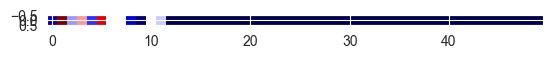

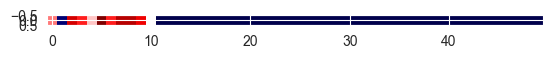

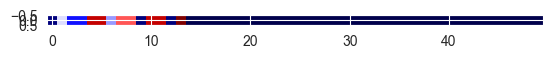

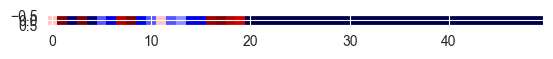

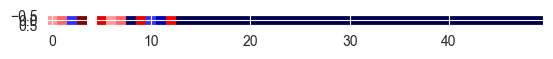

In [20]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [21]:
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)

In [22]:
train_ds_labels = [np.array(x) for x in train_ds_labels]
val_ds_labels = [np.array(x) for x in val_ds_labels]

In [23]:
train_ds_labels = tf.convert_to_tensor(train_ds_labels)
val_ds_labels = tf.convert_to_tensor(val_ds_labels)

In [26]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=train_ds.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
y = Rescaling(scale=1./100)(inputA) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(210, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input], outputs=z)

In [27]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 50, 1)]        0         
                                                                 
 rescaling_1 (Rescaling)     (None, 1, 50, 1)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 50, 128)        512       
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 210)               1344210   
                                                                 
 dense_2 (Dense)             (None, 6)                 1266      
                                                                 
Total params: 1,345,988
Trainable params: 1,345,988
Non-tra

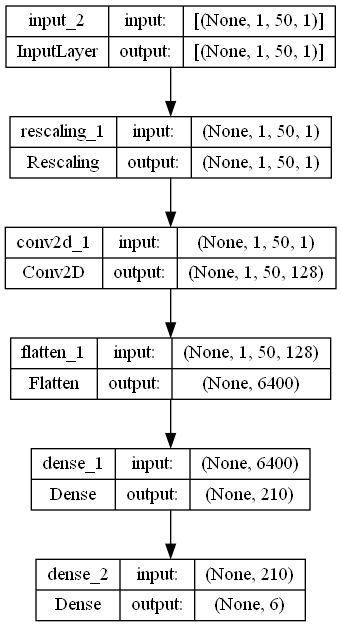

In [28]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [30]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [ ]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit(train_ds, train_ds_labels, epochs=120, batch_size=4096, validation_data=(val_ds, val_ds_labels), callbacks=[checkpoint_callback, early_stopping, WandbCallback()]) #WandbCallback()

In [ ]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
model.save('precursor_charge_prediction_conv2d_model/big_conv2d_model.h5')

# Embedding model test:

In [30]:
main_ds_embed = np.array(merged_df["modified_sequence_vector"]) # to list
main_ds_labels_embed = np.array(merged_df['most_abundant_charge_vector'])

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies_embed, val_indicies_embed = next(sss.split(main_ds_embed, main_ds_labels_embed))
train_ds_embed, train_ds_labels_embed = main_ds_embed[train_indicies_embed], main_ds_labels_embed[train_indicies]
val_ds_embed, val_ds_labels_embed = main_ds_embed[val_indicies_embed], main_ds_labels_embed[val_indicies_embed]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)


In [31]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]

In [32]:
train_ds_labels_embed = [np.array(x) for x in train_ds_labels_embed]
val_ds_labels_embed = [np.array(x) for x in val_ds_labels_embed]

In [33]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_ds_labels_embed = tf.convert_to_tensor(train_ds_labels_embed)
val_ds_labels_embed = tf.convert_to_tensor(val_ds_labels_embed)

In [81]:
train_ds_embed[0]

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([ 500,  600, 1700, 1400, 1000, 1000, 2000,  900,  500,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>

In [87]:
wandb.init(project='precursor_charge_prediction_new')

categorical_accuracy,▁▄▇▇████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁▄▇▇████████████████████████████████████
val_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,149
best_val_loss,0.47463
categorical_accuracy,0.79654
epoch,149
loss,0.46447
val_categorical_accuracy,0.79257


In [34]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
# the first branch operates on the first input
x = Model(inputs=inputA_embed, outputs=inputA_embed)
# the second branch operates on the second input
# input = sequence mit shape (50, 1)
y = Embedding(input_dim=8000, output_dim=50, input_length=50)(inputA_embed)
# output = ???? 8000x50x50
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(64, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model_embed = Model(inputs=[x.input], outputs=z)

In [35]:
model_embed.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            400000    
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 64)                160064    
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 560,454
Trainable params: 560,454
Non-trainable params: 0
_________________________________________________________________


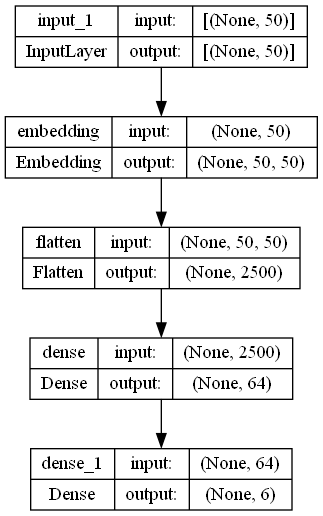

In [36]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [37]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [38]:
checkpoint_callback_embed = ModelCheckpoint('precursor_charge_prediction_model_embed/embed.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_embed = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_ds_labels_embed, epochs=150, batch_size=4096, validation_data=(val_ds_embed, val_ds_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()]) #WandbCallback()

In [41]:
import datetime
date = datetime.datetime.now().strftime("%m%d%Y")
print(date)

08102023


In [42]:
model_embed.save(f'precursor_charge_prediction_model_embed/history_embed_150epoch_{date}.h5')

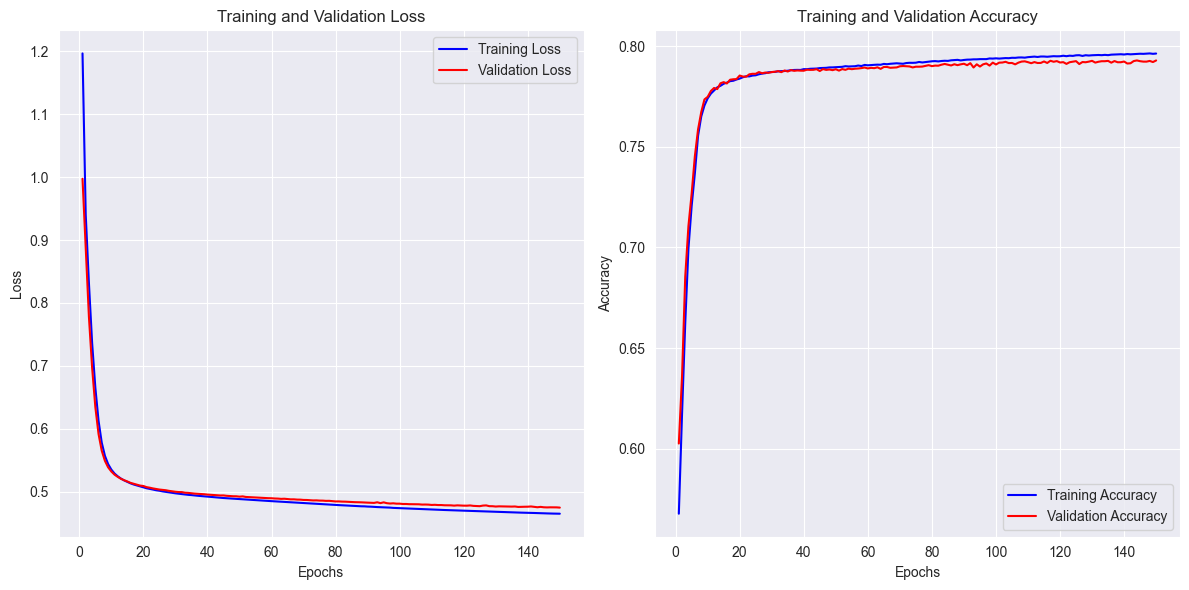

In [43]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
accuracy = history_embed.history['categorical_accuracy']
val_accuracy = history_embed.history['val_categorical_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Inference

In [44]:
file_list[-1]

'data/TUM_third_pool_meta_data.parquet'

In [46]:
batches_parquet[file_list[-1]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,DNYDQLVRIAK,2,141925100.0
1,MDLESQISDMR,2,63760280.0
2,QLQQIERQLK,2,19577780.0
3,PC[UNIMOD:4]C[UNIMOD:4]C[UNIMOD:4]QTTC[UNIMOD:...,2,29736720.0
4,LNTEVTTWRTK,2,59018990.0


In [47]:
# Grouping by "modified_sequence" and aggregating precursor_charge into a list
grouped_df_embed = batches_parquet[file_list[-1]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

for index, row in grouped_df_embed.iterrows():
    grouped_df_embed.at[index, "precursor_charge"] = get_most_abundant(row["precursor_charge"], row["precursor_intensity"])

grouped_df_embed["modified_sequence_vector"] = grouped_df_embed["modified_sequence"].apply(seq_translator)
grouped_df_embed["precursor_charge"] = grouped_df_embed["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
grouped_df_embed.rename(columns={"precursor_charge": "most_abundant_charge_vector"}, inplace=True)
grouped_df_embed = grouped_df_embed.drop("precursor_intensity", axis=1)
grouped_df_embed = grouped_df_embed.drop("modified_sequence", axis=1)
grouped_df_embed

C:\Users\micro\AppData\Local\Temp\ipykernel_14408\1872002653.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df_embed = batches_parquet[file_list[-1]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


,most_abundant_charge_vector,modified_sequence_vector
0,"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100..."
1,"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100..."
2,"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900..."
3,"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900..."
4,"[0, 0, 1, 0, 0, 0]","[100, 100, 800, 1500, 1000, 400, 1000, 500, 10..."
...,...,...
4353,"[0, 0, 1, 0, 0, 0]","[2000, 1800, 100, 800, 204, 1200, 1300, 1000, ..."
4354,"[0, 0, 1, 0, 0, 0]","[2000, 1800, 100, 800, 204, 1600, 1300, 1000, ..."
4355,"[0, 0, 1, 0, 0, 0]","[2000, 1800, 100, 800, 204, 1600, 1300, 1000, ..."
4356,"[0, 0, 1, 0, 0, 0]","[2000, 1800, 1000, 1700, 1600, 1300, 1500, 160..."


In [48]:
grouped_df_embed['modified_sequence_vector'] = grouped_df_embed['modified_sequence_vector'].apply(lambda x: np.array(x))

In [49]:
# size of df
grouped_df_embed.shape

(4358, 2)

In [ ]:
# ValueError: Layer "model_1" expects 1 input(s), but it received 33732 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 50) dtype=int32>, <tf.Tensor

In [ ]:
# solut = [np.expand_dims(tf.convert_to_tensor(np.array(x)), axis=0) for x in grouped_df_embed["modified_sequence_vector"]]
# predictions = model_embed.predict(solut, batch_size=4096, verbose=True)

In [50]:
grouped_df_embed['prediction'] = None
for index, row in grouped_df_embed.iterrows():
    solut = np.expand_dims(tf.convert_to_tensor(np.array(grouped_df_embed.at[index, "modified_sequence_vector"])), axis=0)
    grouped_df_embed.at[index, 'prediction'] = model_embed.predict(solut, verbose=False)

In [51]:
def decode_one_hot(one_hot, charges = [1,2,3,4,5,6]):
    for index, hot in enumerate(one_hot):
        if hot == 1:
            return charges[index]

In [52]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    index = np.argmax(one_hot)
    return(charges[index])

In [53]:
np.argmax([0, 0 ,0 ,0, 1])

4

In [54]:
grouped_df_embed['true_label'] = grouped_df_embed['most_abundant_charge_vector'].apply(decode_one_hot)

In [55]:
grouped_df_embed['pred_label'] = grouped_df_embed['prediction'].apply(predictions_no_hot)

In [56]:
grouped_df_embed.head(4)

,most_abundant_charge_vector,modified_sequence_vector,prediction,true_label,pred_label
0,"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100...","[[9.0525085e-05, 0.35126275, 0.64825, 0.000396...",3,3
1,"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100...","[[1.3091594e-08, 0.04320802, 0.30506778, 0.618...",3,4
2,"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900...","[[0.06276861, 0.93675226, 0.00047866072, 4.076...",2,2
3,"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900...","[[0.00080282247, 0.8499214, 0.1492342, 4.14584...",2,2


In [57]:
# iterate all rows of grouped_df_embed
size_of_df = grouped_df_embed.shape[0]
true_counter = 0
for index, row in grouped_df_embed.iterrows():
    if row['true_label'] == row['pred_label']:
        true_counter += 1

print(true_counter/size_of_df, true_counter, size_of_df)

0.8838916934373566 3852 4358


[[   0    2    0    0    0    0]
 [   0 1393  143    2    0    0]
 [   0  118 2005  118    3    0]
 [   0    2   85  445   19    1]
 [   0    0    3    7    9    0]
 [   0    0    0    2    1    0]]
Accuracy:  0.8838916934373566
Precision:  0.8856377649855041
Recall:  0.8838916934373566
F1:  0.8845998195607331


C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


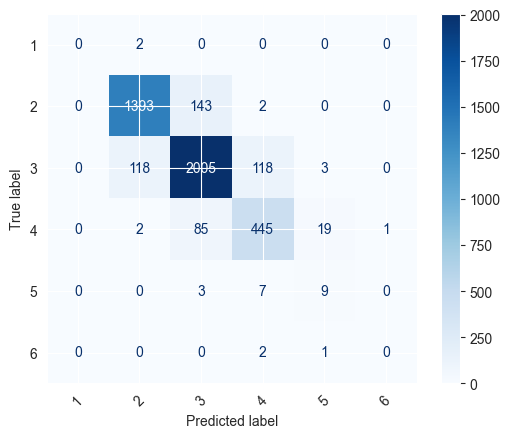

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

true_labels = grouped_df_embed['true_label']
predicted_labels = grouped_df_embed['pred_label']

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
print("Precision: ", precision_score(true_labels, predicted_labels, average='weighted'))
print("Recall: ", recall_score(true_labels, predicted_labels, average='weighted'))
print("F1: ", f1_score(true_labels, predicted_labels, average='weighted'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

In [80]:
from sklearn.metrics import confusion_matrix

new_df = pd.DataFrame(columns=['charge','accuracy'])

matrix = confusion_matrix(true_labels, predicted_labels)
new_df['charge'] = [1,2,3,4,5,6]
new_df['accuracy'] = matrix.diagonal()/matrix.sum(axis=1)


In [81]:
new_df

,charge,accuracy
0,1,0.000000
1,2,0.905722
2,3,0.893494
3,4,0.806159
4,5,0.473684
5,6,0.000000


In [82]:
grouped_df_embed.head(4)

,most_abundant_charge_vector,modified_sequence_vector,prediction,true_label,pred_label
0,"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100...","[[9.0525085e-05, 0.35126275, 0.64825, 0.000396...",3,3
1,"[0, 0, 1, 0, 0, 0]","[100, 100, 100, 700, 600, 1400, 1900, 400, 100...","[[1.3091594e-08, 0.04320802, 0.30506778, 0.618...",3,4
2,"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900...","[[0.06276861, 0.93675226, 0.00047866072, 4.076...",2,2
3,"[0, 1, 0, 0, 0, 0]","[100, 100, 400, 100, 300, 600, 1300, 1000, 900...","[[0.00080282247, 0.8499214, 0.1492342, 4.14584...",2,2


# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [35]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
5      34381
1      26371
6       4417
Name: precursor_charge, dtype: int64

In [36]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

OSError: No file or directory found at precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5

In [ ]:
batches_parquet.keys()

In [ ]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [37]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

NameError: name 'inference_df' is not defined

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [38]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

NameError: name 'inference_df' is not defined

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [39]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [40]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

NameError: name 'true_labels' is not defined

MCC

In [41]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

NameError: name 'true_labels' is not defined

Direct eval:

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [43]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

NameError: name 'test_ds' is not defined

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')